## Question 2

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd
import math

from scipy.io import wavfile as wav
from scipy.signal import gaussian

In [55]:
sr, ocean_wav = wav.read('./data/ocean.wav')
sr, piano_wav = wav.read('./data/piano.wav')

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [56]:
ipd.Audio(ocean_wav, rate=sr)

In [57]:
ipd.Audio(piano_wav, rate=sr)

### Example of DFT as matrix when N = 16

In [58]:
N = 16
seq_array = np.array(range(N), ndmin=2)
F = np.exp(-1j*(2*math.pi*np.dot(seq_array.T,seq_array)/N))

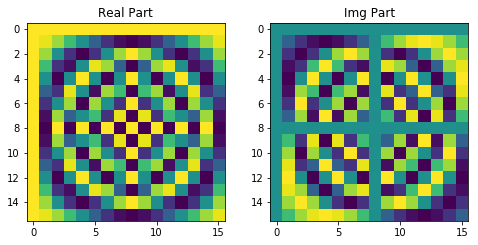

In [59]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.title("Real Part")
plt.imshow(F.real)
plt.subplot(2,2,2)
plt.title("Img Part")
plt.imshow(F.imag)
plt.show()

in this case N = 1024 so,

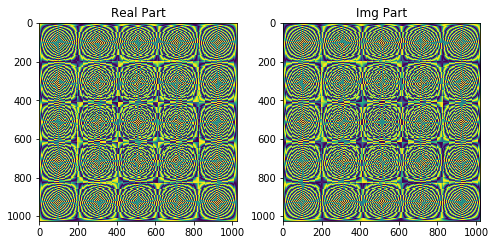

In [60]:
point_frames = 1024
hop_size = int(point_frames/2)
signal_len = len(piano_wav)
seq_array = np.array(range(point_frames), ndmin=2)
F = np.exp(-1j*(2*math.pi*np.dot(seq_array.T,seq_array)/point_frames))
plt.figure(figsize=(8,8))
plt.subplot(2,2,1); plt.title("Real Part"); plt.imshow(F.real)
plt.subplot(2,2,2); plt.title("Img Part"); plt.imshow(F.imag)
plt.show()

### Data Matrix representation for ocean and piano waves

In [79]:
def STFT(x):
    "50% Over lap and add"
    x = np.concatenate((x, np.zeros(896)), axis=0)
    signal_len = x.shape[0]
    bell_curve = scipy.signal.gaussian(M=point_frames, std=np.std(np.arange(point_frames)))
    X = (x[:point_frames] * bell_curve).reshape((point_frames,1))
    start = 0
    
    while True:
#         print(start, start+point_frames)
        hann_window = (x[start:start+point_frames] * bell_curve).reshape((point_frames, 1))
        X = np.concatenate((X, hann_window), axis=1)
        start = int(start + hop_size)
#         print(signal_len < start+point_frames)
        if signal_len < start + point_frames:
            break
    
    stft = np.dot(F, X)
    
    return stft

S = STFT(piano_wav)
N = STFT(ocean_wav)

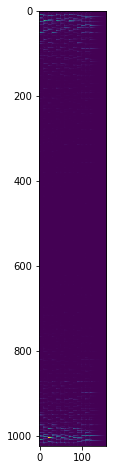

In [80]:
plt.figure(figsize=(8,8))
plt.imshow(np.absolute(S))
plt.show()

In [81]:
S, N = S[:513,], N[:513,]

### mixture spectrogram

In [82]:
X = S + N

### Mask generation

In [83]:
M = S/X

### 1. ideal masks

In [84]:
# S = np.multiply(M, X) # using the below method

### 2. masks when there is no phase

In [85]:
# M_bar = np.square(S)/(np.square(S) + np.square(N))
# S = np.multiply(M_bar, X)

### 3. Ideal Binary masks

In [94]:
B_ft = np.where(np.absolute(S)>np.absolute(N), 1,0)
S_ = np.multiply(B_ft, X)

### Signal reconstruction

In [96]:
S_recovered = np.concatenate((S_, np.array([np.conjugate(S_[s]) for s in range(512,1, -1)])), axis=0)
S_recovered = np.array(S_recovered)

In [97]:
print(S_recovered.shape)

(1024, 158)


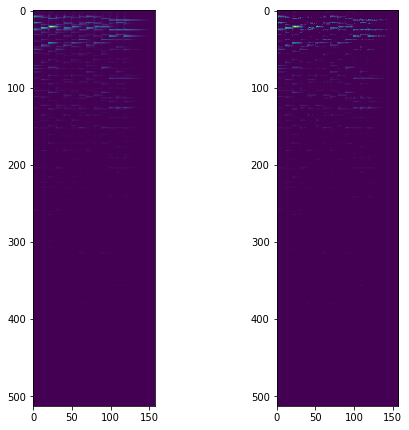

In [98]:
plt.figure(figsize=(8,16))
plt.subplot(2,2,1)
plt.imshow(np.absolute(S))
plt.subplot(2,2,2)
plt.imshow(np.absolute(S_[:513]))
plt.show()

### Inv fourier transform

In [99]:
piano_wav_recovered = (1/point_frames)*np.dot(S_recovered.T, 
                                                  np.exp(-1j*(2*math.pi*np.dot(seq_array.T,seq_array)/point_frames))).real
piano_wav_reconstructed = np.zeros(int(piano_wav_recovered.shape[0]*piano_wav_recovered.shape[1]/2))

### signal reconstruction

In [100]:
piano_wav_reconstructed.shape

(80896,)

In [103]:
start = 0
i = 0
while True:
    piano_wav_reconstructed[start:start+point_frames] += piano_wav_recovered[i]
    start += hop_size
    i += 1
    if start+point_frames  > signal_len:
        break
        
ipd.Audio(piano_wav_reconstructed, rate=sr) # load a local WAV file

In [104]:
SNR = 10*np.log(np.sum(np.square(piano_wav))/np.sum(np.square(piano_wav - piano_wav_reconstructed[:len(piano_wav)])))
SNR

-112.20411743007018

In [33]:
B_ft

array([[0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ..., 
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1]])